In [1]:
pip install -q -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np

from statsforecast import StatsForecast
import time
from statsforecast.models import (
    HistoricAverage,
    DynamicOptimizedTheta as DOT,
    SeasonalNaive,
    AutoARIMA,
    AutoETS,
    Naive
)
from utilsforecast.losses import *
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS
from utilsforecast.evaluation import evaluate

from functools import partial
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import AutoModelForCausalLM
from chronos import BaseChronosPipeline
import scipy.stats as stats 

import lightgbm as lgb
from sklearn.linear_model import LinearRegression

from importlib import reload
import utils
reload(utils)

from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, RollingMean
from mlforecast.target_transforms import Differences

from utils import prepare_data, TimeMoEPredictor, chronosPredictor

/Users/xcx7787/m4_tests/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-06 18:11:35,567	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-12-06 18:11:35,664	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


## Prepare data

In [3]:
train, test = prepare_data(sample_size=1000,series_cutoff=48)

/Users/xcx7787/m4_tests/utils.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  .assign(StartingDate = lambda x : pd.to_datetime(x["StartingDate"]))
/Users/xcx7787/m4_tests/utils.py:37: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  df["max"] = df.groupby("unique_id")["row"].transform(max)


In [4]:
# Create a list of models and instantiation parameters
season_length = 12

models_classes_stats = [
    DOT(season_length=season_length),
    AutoARIMA(),
    AutoETS(),
    Naive()
]

model_classes_neural = [
    NBEATS(h=3, input_size=10,
               stack_types = ['identity', 'trend', 'seasonality']
            )
]

model_classes_ml = [
    lgb.LGBMRegressor(random_state=0, verbosity=-1),
    LinearRegression(),
]

model_classes_custom = [TimeMoEPredictor(input_length=24),chronosPredictor(input_length=24)]


Seed set to 1
/Users/xcx7787/m4_tests/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [5]:
model_wrappers = []
model_names = []

neural = True
stats = True
ML = True
custom = True

if neural:
    for model in model_classes_neural:
        model_names.append(str(model))
        model_wrappers.append(
            NeuralForecast( 
                models=[model],
                freq="ME"
            )
        )    

if stats:
    for model in models_classes_stats:
        model_names.append(str(model))
        model_wrappers.append(
            StatsForecast( 
                models=[model],
                freq="ME", 
                fallback_model = SeasonalNaive(season_length=12),
                n_jobs=-1,
            )
        )    

if ML:
    for model in model_classes_ml:
        model_names.append(str(model).split("(")[0])
        model_wrappers.append(
            MLForecast(
                models=model,
                freq='ME',
                lags=[1,2,3,4,5,6,7,8,9,10],
                lag_transforms={
                    1: [ExpandingMean(),RollingMean(window_size=12),RollingMean(window_size=3),RollingMean(window_size=6),RollingMean(window_size=12)],        
                },
                date_features=['dayofweek'],
                target_transforms=[Differences([1])],
            )
        )

if custom:
    for model in model_classes_custom:
        model_names.append(str(type(model).__name__))

In [6]:
model_wrappers[5].preprocess(train)

/Users/xcx7787/m4_tests/.venv/lib/python3.11/site-packages/mlforecast/core.py:380: RuntimeWarning: invalid value encountered in cast
  feat_vals = feat_vals.astype(feat_dtype)


,unique_id,y,ds,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,expanding_mean_lag1,rolling_mean_lag1_window_size12,rolling_mean_lag1_window_size3,rolling_mean_lag1_window_size6,dayofweek
13,M10000,110.0,2014-06-30,230.0,30.0,60.0,-190.0,-140.0,-10.0,20.0,-140.0,-50.0,-120.0,-0.833333,-0.833333,106.666667,-3.333333,0
14,M10000,0.0,2014-07-31,110.0,230.0,30.0,60.0,-190.0,-140.0,-10.0,20.0,-140.0,-50.0,7.692308,-13.333333,123.333333,16.666667,3
15,M10000,-40.0,2014-08-31,0.0,110.0,230.0,30.0,60.0,-190.0,-140.0,-10.0,20.0,-140.0,7.142857,-16.666667,113.333333,40.000000,6
16,M10000,-20.0,2014-09-30,-40.0,0.0,110.0,230.0,30.0,60.0,-190.0,-140.0,-10.0,20.0,4.000000,-10.000000,23.333333,65.000000,1
17,M10000,-220.0,2014-10-31,-20.0,-40.0,0.0,110.0,230.0,30.0,60.0,-190.0,-140.0,-10.0,2.500000,-7.500000,-20.000000,51.666667,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47992,M9964,40.0,2016-08-31,80.0,60.0,-40.0,40.0,40.0,-20.0,-30.0,-170.0,-160.0,10.0,-9.743590,-20.833333,33.333333,26.666667,2
47993,M9964,-70.0,2016-09-30,40.0,80.0,60.0,-40.0,40.0,40.0,-20.0,-30.0,-170.0,-160.0,-8.500000,-20.833333,60.000000,36.666667,4
47994,M9964,0.0,2016-10-31,-70.0,40.0,80.0,60.0,-40.0,40.0,40.0,-20.0,-30.0,-170.0,-10.000000,-18.333333,16.666667,18.333333,0
47995,M9964,-20.0,2016-11-30,0.0,-70.0,40.0,80.0,60.0,-40.0,40.0,40.0,-20.0,-30.0,-9.761905,-19.166667,-10.000000,11.666667,2


In [7]:
fit_times = []

for model in model_wrappers:
    print(model)
    start = time.time()
    model.fit(df=train)
    fit_times.append(time.time()-start)
    

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.4 M  | train
-------------------------------------------------------
2.4 M     Trainable params
91        Non-trainable params
2.4 M     Total params
9.579     Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 31:  25%|██▌       | 8/32 [00:00<00:00, 40.41it/s, v_num=104, train_loss_step=382.0, train_loss_epoch=338.0] 

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 31:  25%|██▌       | 8/32 [00:00<00:00, 40.10it/s, v_num=104, train_loss_step=382.0, train_loss_epoch=338.0]
StatsForecast(models=[DynamicOptimizedTheta])
StatsForecast(models=[AutoARIMA])
StatsForecast(models=[AutoETS])
StatsForecast(models=[Naive])
MLForecast(models=[LGBMRegressor], freq=ME, lag_features=['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'expanding_mean_lag1', 'rolling_mean_lag1_window_size12', 'rolling_mean_lag1_window_size3', 'rolling_mean_lag1_window_size6'], date_features=['dayofweek'], num_threads=1)


/Users/xcx7787/m4_tests/.venv/lib/python3.11/site-packages/mlforecast/core.py:380: RuntimeWarning: invalid value encountered in cast
  feat_vals = feat_vals.astype(feat_dtype)


MLForecast(models=[LinearRegression], freq=ME, lag_features=['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'expanding_mean_lag1', 'rolling_mean_lag1_window_size12', 'rolling_mean_lag1_window_size3', 'rolling_mean_lag1_window_size6'], date_features=['dayofweek'], num_threads=1)


/Users/xcx7787/m4_tests/.venv/lib/python3.11/site-packages/mlforecast/core.py:380: RuntimeWarning: invalid value encountered in cast
  feat_vals = feat_vals.astype(feat_dtype)


In [8]:
model_wrappers=model_wrappers+model_classes_custom

In [9]:
forecasts = []
forecast_times = []

for model in model_wrappers:
    print(model)
    
    start = time.time()

    if isinstance(model, NeuralForecast):
        forecasts.append(model.predict().reset_index())   
    elif (isinstance(model,StatsForecast)) or (isinstance(model,MLForecast)):
        forecasts.append(model.predict(h=3))
    else:
        forecasts.append(model.predict(train,test,h=3))
        fit_times.append(0)

    forecast_times.append(time.time()-start)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 32/32 [00:00<00:00, 152.67it/s]
StatsForecast(models=[DynamicOptimizedTheta])


/Users/xcx7787/m4_tests/.venv/lib/python3.11/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


StatsForecast(models=[AutoARIMA])
StatsForecast(models=[AutoETS])
StatsForecast(models=[Naive])
MLForecast(models=[LGBMRegressor], freq=ME, lag_features=['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'expanding_mean_lag1', 'rolling_mean_lag1_window_size12', 'rolling_mean_lag1_window_size3', 'rolling_mean_lag1_window_size6'], date_features=['dayofweek'], num_threads=1)
MLForecast(models=[LinearRegression], freq=ME, lag_features=['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'expanding_mean_lag1', 'rolling_mean_lag1_window_size12', 'rolling_mean_lag1_window_size3', 'rolling_mean_lag1_window_size6'], date_features=['dayofweek'], num_threads=1)


/Users/xcx7787/m4_tests/.venv/lib/python3.11/site-packages/mlforecast/core.py:380: RuntimeWarning: invalid value encountered in cast
  feat_vals = feat_vals.astype(feat_dtype)
/Users/xcx7787/m4_tests/.venv/lib/python3.11/site-packages/mlforecast/core.py:380: RuntimeWarning: invalid value encountered in cast
  feat_vals = feat_vals.astype(feat_dtype)
/Users/xcx7787/m4_tests/.venv/lib/python3.11/site-packages/mlforecast/core.py:380: RuntimeWarning: invalid value encountered in cast
  feat_vals = feat_vals.astype(feat_dtype)
/Users/xcx7787/m4_tests/.venv/lib/python3.11/site-packages/mlforecast/core.py:380: RuntimeWarning: invalid value encountered in cast
  feat_vals = feat_vals.astype(feat_dtype)
/Users/xcx7787/m4_tests/.venv/lib/python3.11/site-packages/mlforecast/core.py:380: RuntimeWarning: invalid value encountered in cast
  feat_vals = feat_vals.astype(feat_dtype)
/Users/xcx7787/m4_tests/.venv/lib/python3.11/site-packages/mlforecast/core.py:380: RuntimeWarning: invalid value encount

1000
3000


In [10]:
forecast_times

[0.26427412033081055,
 5.707134008407593,
 2.0786778926849365,
 2.046570062637329,
 2.1991641521453857,
 0.009401082992553711,
 0.004483222961425781,
 5.5084452629089355,
 0.514887809753418]

In [11]:
forecasts[0]

,unique_id,ds,NBEATS
0,M10000,2017-01-31,2315.308838
1,M10000,2017-02-28,2162.373291
2,M10000,2017-03-31,2056.003662
3,M10127,2016-07-31,1107.351440
4,M10127,2016-08-31,1108.363647
...,...,...,...
2995,M9942,2017-02-28,1719.952759
2996,M9942,2017-03-31,1716.451172
2997,M9964,2017-01-31,513.163635
2998,M9964,2017-02-28,502.868744


In [12]:
def _zero_to_nan(series: pd.Series) -> pd.Series:
    if isinstance(series, pd.Series):
        res = series.replace(0, np.nan)
    return res

def wape(
    df:  pd.DataFrame,
    models: list[str],
    id_col: str = "unique_id",
    target_col: str = "y",
) ->  pd.DataFrame:
    """Mean Absolute Percentage Error (WAPE)

    WAPE measures the relative prediction
    accuracy of a forecasting method by calculating the percentual deviation
    of the prediction and the observed value at a given time and
    averages these devations over the length of the series.
    The closer to zero an observed value is, the higher penalty WAPE loss
    assigns to the corresponding error."""
    if isinstance(df, pd.DataFrame):
        res = (
            df[models]
            .sub(df[target_col], axis=0)
            .abs()
            .div(_zero_to_nan(df[target_col].abs().sum()), axis=0)
            .groupby(df[id_col], observed=True)
            .mean()
        )
        res.index.name = id_col
        res = res.reset_index()

    return res

In [13]:
metrics = [
    mape,
    rmse,
    wape,
    partial(mase, seasonality=12),
    partial(rmsse, seasonality=12),
]

In [14]:
test = test.reset_index()

for forecast in forecasts:
    test = test.merge(forecast, on = ["ds","unique_id"],how="inner")

In [15]:
eval = evaluate(test, metrics=metrics, train_df=train)

UnboundLocalError: cannot access local variable 'res' where it is not associated with a value

In [39]:
metrics = eval.drop(columns="index").set_index(["unique_id","metric"]).stack().rename_axis(index={None: 'Model'}).rename("value")

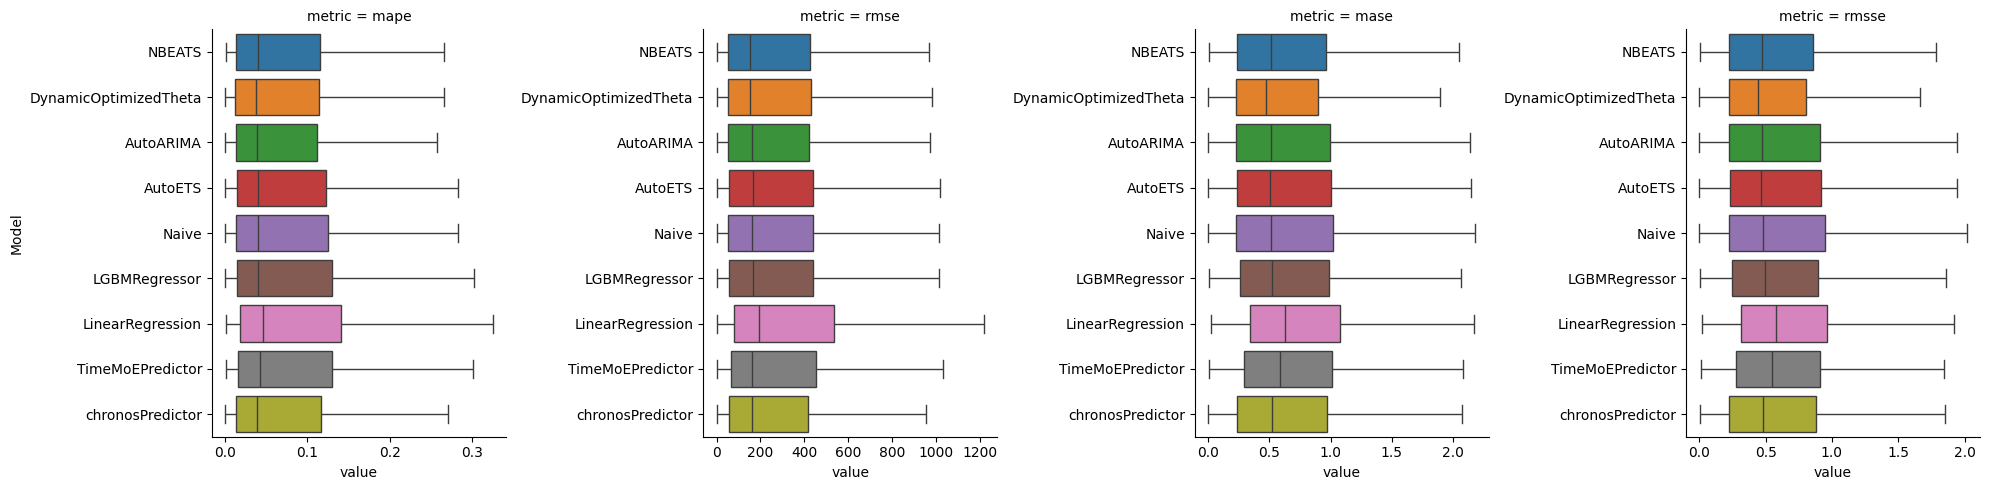

In [40]:
sns.catplot(
    data=metrics.reset_index(), x='value', y='Model',hue="Model",sharey=False,sharex=False,showfliers=False,
    col='metric', kind='box', col_wrap=4
)

In [41]:
times = pd.DataFrame(
    {
        "Model":model_names,
        "fit_time":fit_times,
        "inference_time":forecast_times
    }
).set_index("Model")

In [42]:
times

,fit_time,inference_time
Model,,
NBEATS,17.632864,0.214088
DynamicOptimizedTheta,15.613503,6.039796
AutoARIMA,16.989109,2.224697
AutoETS,2.671610,2.204751
Naive,2.395918,2.107725
LGBMRegressor,0.254930,0.011778
LinearRegression,0.024241,0.004831
TimeMoEPredictor,0.000000,5.961116
chronosPredictor,0.000000,0.374330


In [43]:
metrics.groupby(level=[1,2]).median().unstack()

Model,AutoARIMA,AutoETS,DynamicOptimizedTheta,LGBMRegressor,LinearRegression,NBEATS,Naive,TimeMoEPredictor,chronosPredictor
metric,,,,,,,,,
mape,0.038512,0.040203,0.037035,0.040328,0.046229,0.040322,0.040214,0.041787,0.039209
mase,0.516533,0.502563,0.475772,0.526787,0.631464,0.513598,0.515858,0.586734,0.521557
rmse,161.633756,164.476500,151.446931,167.656794,192.529232,154.226982,163.230922,162.940932,159.490566
rmsse,0.472186,0.464999,0.446007,0.493683,0.577177,0.473542,0.482381,0.546806,0.481660


In [44]:
md = metrics.groupby(level=[1,2]).median().to_frame().join(times).set_index("value",append=True).stack().rename_axis(index={None: 'time'}).rename("time_value").reset_index()

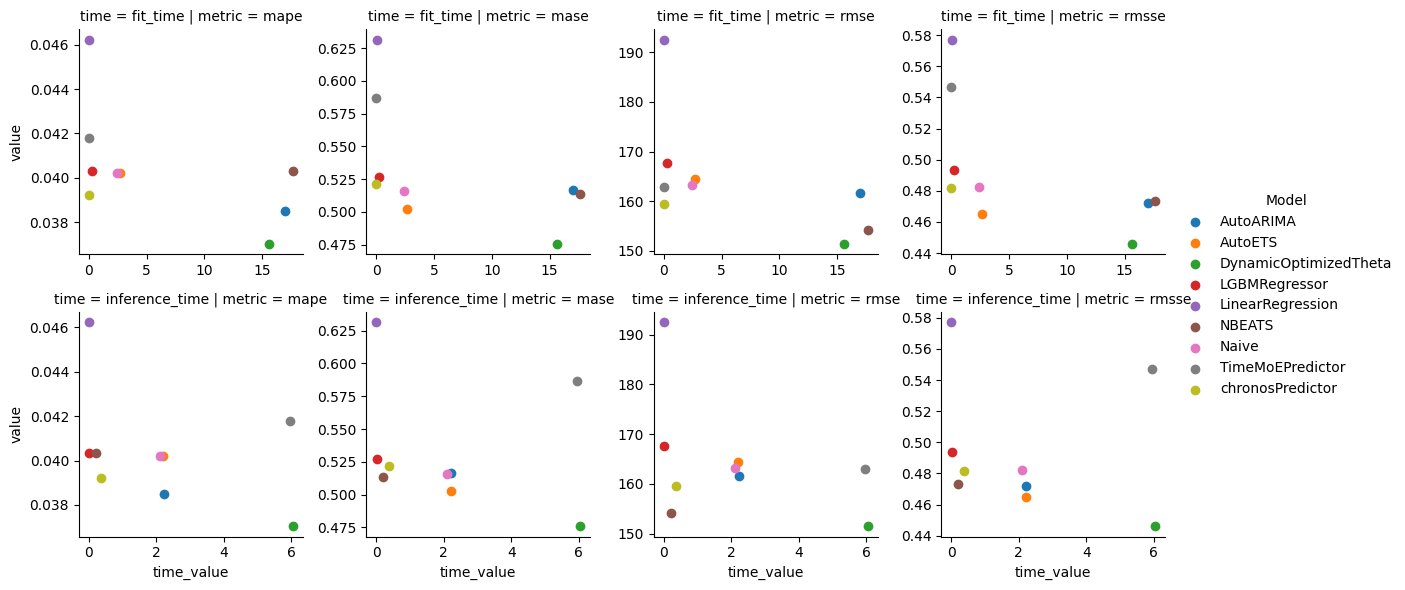

In [45]:
g = sns.FacetGrid(md, row= "time", col="metric", hue = "Model",sharey=False,sharex=False)
g = g.map(plt.scatter, "time_value", "value")
g.add_legend()